# Medical MNIST

## In this notebook i will train machine learning model with fast.ai for multi-label classification on datasets Medical MNIST. It's simular to "Hello World" in data science in medicine field.
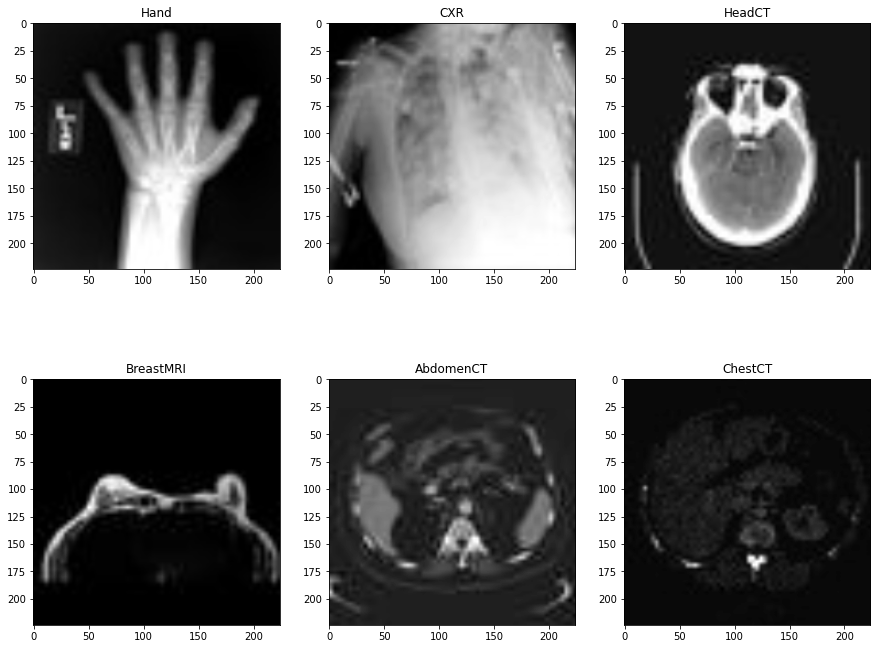



In [1]:
# allowing for any single variable to print out without using the print statement:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from fastai.vision.all import *
from fastai.vision import *
import pandas as pd
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
from torch.utils import model_zoo

%matplotlib inline


from torchvision.models import resnet34

Check our GPU is on

In [3]:
import torch
torch.cuda.is_available()

True

# Load train dataset

In [4]:
train_images = r"D:\Docs\My Projects\Kaggle\Medical MNIST (Multilabel_classification)\Medical_MNIST\split_dataset\train"
len(get_image_files(train_images))

47163

Check how many files in 'test' folder

In [5]:
test_images = r"D:\Docs\My Projects\Kaggle\Medical MNIST (Multilabel_classification)\Medical_MNIST\split_dataset\test"
len(get_image_files(test_images))

5896

Check classnames

In [6]:
print(os.listdir(train_images))

['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


Load data to dls loader. This object used for load data to our model and set some parameters, include train on GPU devices.

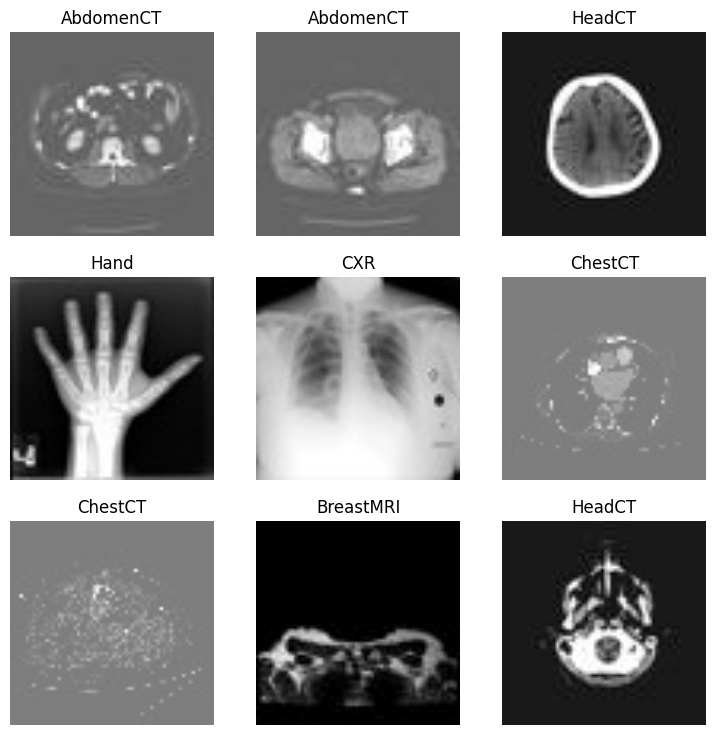

In [7]:
dls = ImageDataLoaders.from_folder(
    train_images, get_image_files(train_images), valid_pct=0.2, seed=42, item_tfms=Resize(192), device='cuda')

dls.train.show_batch()

Let's see how many pics we have in each class

In [8]:
import os
import pandas as pd


def count_examples_per_label(data_dir, classes):
    label_counts = {label: 0 for label in classes}
    for label in classes:
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            label_counts[label] = len(os.listdir(label_dir))

    df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
    return df


classes = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']
df_counts = count_examples_per_label(train_images, classes)

print(df_counts)

       Label  Count
0  AbdomenCT   8000
1  BreastMRI   7163
2    ChestCT   8000
3        CXR   8000
4       Hand   8000
5     HeadCT   8000


In [9]:
# learn = vision_learner(dls, resnet34, metrics=(
#     Precision(average="macro"), Recall(average="macro"), accuracy, error_rate), model_dir="../tmp/model/")

# lr_steep = learn.lr_find()

Go to learner for load model 'resnet34' and set 'accuracy' metric

In [10]:
learn = cnn_learner(dls,
                    models.resnet34,
                    metrics=[accuracy],
                    path='.')

C:\Users\idirt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0010000000474974513)

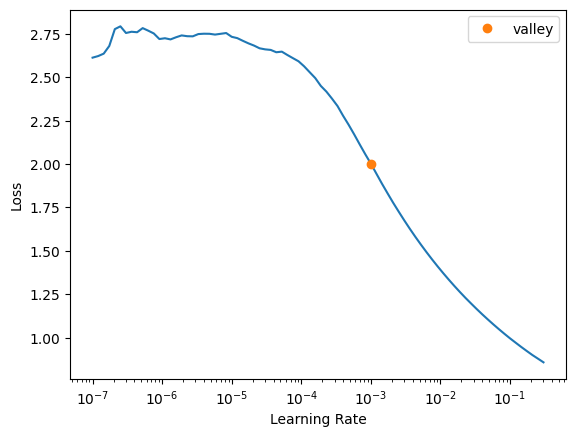

In [11]:
learn.lr_find()

Set learning rate for model

In [16]:
lr = 4e-3
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.013374,0.005422,0.001802,01:50
1,0.006445,0.000006,0.000000,01:50
2,0.000928,0.000052,0.000000,01:47
3,0.000398,0.000000,0.000000,01:46
4,0.000006,0.000005,0.000000,01:47


Plot top losses on train

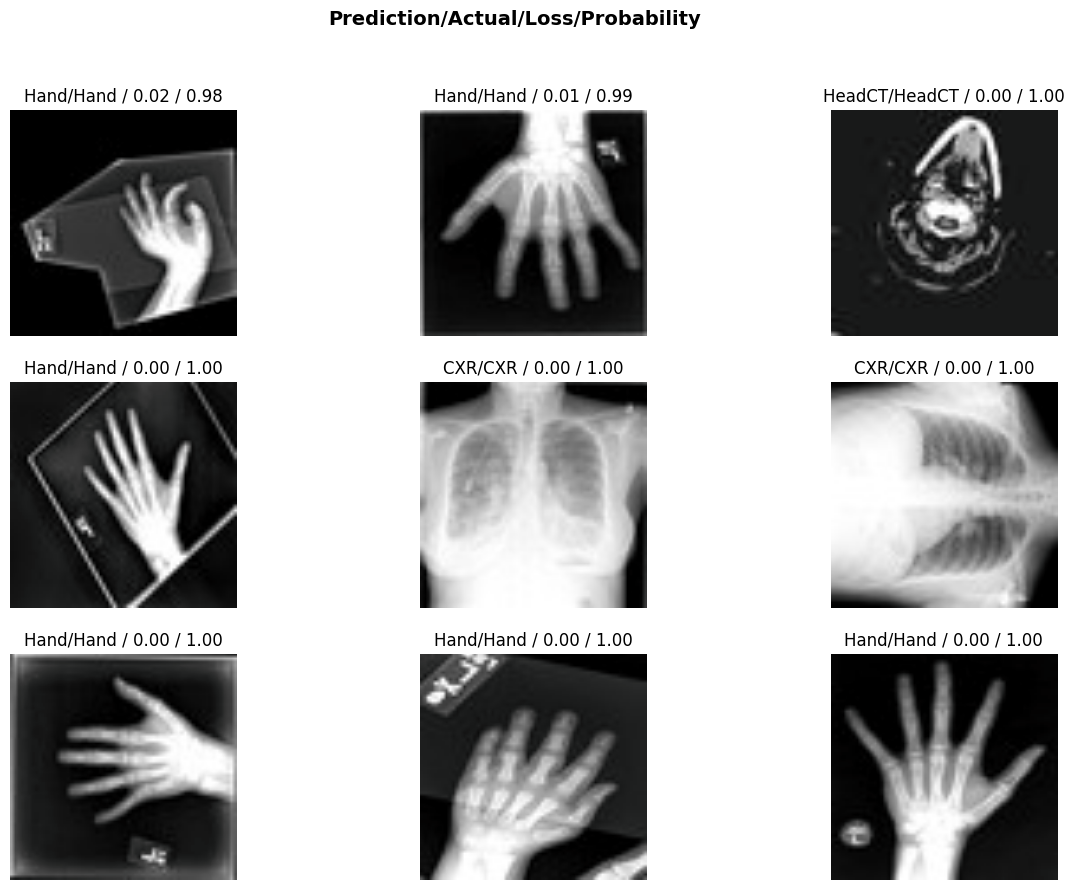

In [13]:
learn.metrics += [F1Score(average="macro")]
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15, 10))

Plot the confusion matrix

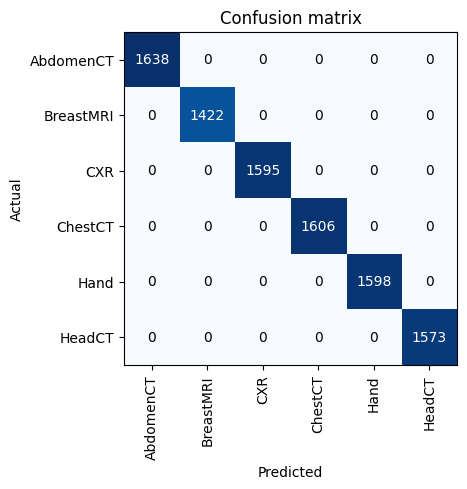

In [14]:
# Plot confusion matrix
interp.plot_confusion_matrix()

# Create test-loader for validation

Load to model test dataset

In [48]:
path = Path(
    'D:/Docs/My Projects/Kaggle/Medical MNIST (Multilabel_classification)/Medical_MNIST/split_dataset/val')
val_files = get_image_files(path)

dls_val = ImageDataLoaders.from_name_re(
    path, val_files, pat=r'.*\.(png|jpg|jpeg)$', item_tfms=Resize(192))

val_batch = dls_val.one_batch()
val_x, val_y = val_batch

print(val_x.shape)

torch.Size([64, 3, 192, 192])


Show test batch

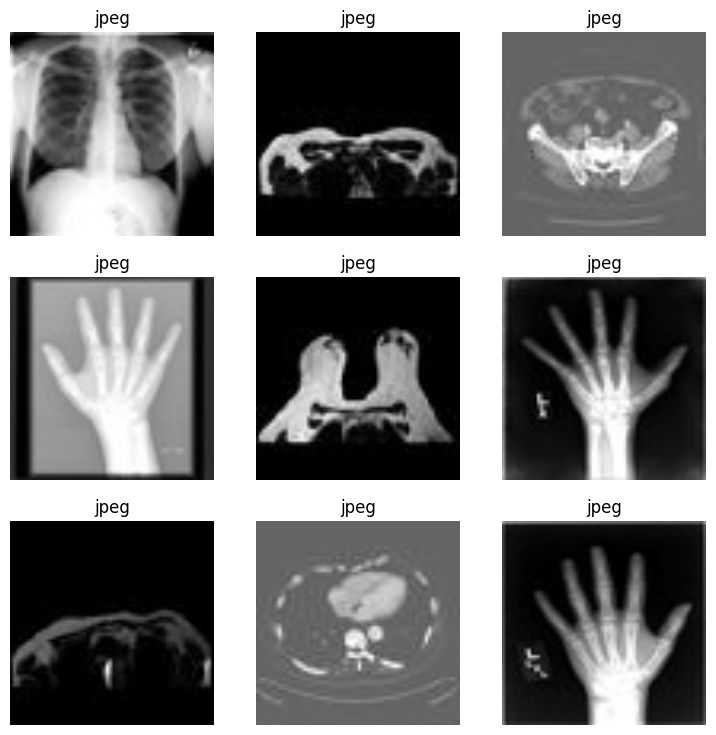

In [49]:
dls_val.show_batch(max_n=9, nrows=3)

Save our model to folder

In [50]:
learn.export(fname=r'D:\Docs\My Projects\Kaggle\Medical MNIST (Multilabel_classification)\Medical_MNIST\split_dataset\medical-mnist.pkl')

Now let's try to use **Half-precision floating-point format** numbers.

See more info on my Kaggle notebook for this solution: https://www.kaggle.com/code/gennadiimanzhos/fast-machine-learning-on-gpu-with-mixed-accuracy

In [53]:
from fastai.callback.fp16 import *

learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(5, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,0.007262,0.001100,0.000212,04:25
1,0.004093,0.000108,0.000000,01:48
2,0.000702,0.000296,0.000106,01:48


epoch,train_loss,valid_loss,error_rate,time
0,0.005777,0.004773,0.001060,02:05
1,0.000035,0.000303,0.000106,07:00
2,0.005373,0.001547,0.000742,02:08
3,0.000349,0.000128,0.000106,02:05
4,0.000020,0.000000,0.000000,02:04


Plot loss grapchic for train/valid

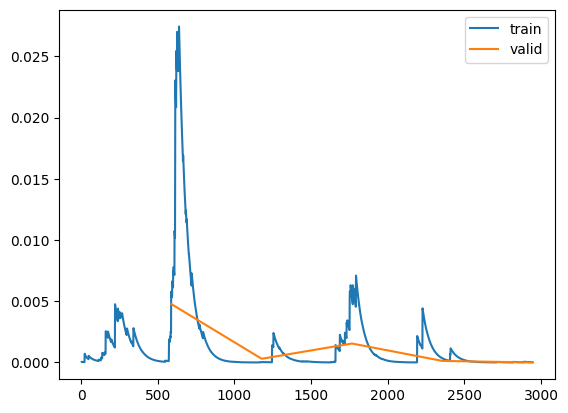

In [54]:
learn.recorder.plot_loss()

Load random image from test data for predict class

In [55]:
img = PILImage.create(
    r"D:\Docs\My Projects\Kaggle\Medical MNIST (Multilabel_classification)\Medical_MNIST\split_dataset\val\Hand\000063.jpeg")

print(learn.predict(img)[0])

Hand
